# AI EU Project #

In [100]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_excel('pstw_dataset.xlsx')

## Drop unnused columns ##

In [105]:
# Ensures all the projects are within AI 
df = df[df['Primary Technology'].str.lower() == 'artificial intelligence']

# This will be the hyperparameter used when modelling
df_y = df[' Status']
df_y = df_y.reset_index(drop=True)

current_year = 2025

df['Duration_years'] = df["End Year"].fillna(current_year) - df["Start Year"]

df = df.dropna(subset=["Start Year"]).reset_index(drop=True)

# Replaces Pilot phase with pilot for consistensy
df[' Status'] = df[' Status'].replace({'Pilot phase': 'Pilot'})
y_time = df["Duration_years"]

# Resets the indexing so that it will match the other data when modelling

# All columns needed for the project
columns = [
    "Geographical extent",
    "Functions of Government (COFOG level I)",
    "Functions of Government (COFOG level II)",
    "Process type",
    "Application type",
    "Cross Border",
    "Cross Sector",
    "Interaction",
    "Increase quality of PSI and services",
    "Improved management of public resources",
    "Increased quality of processes and systems",
    "AI Classification (I)",
    "AI Classification Subdomain (II) (main)",
    "AI Classification Subdomain (II) (Other I)",
    "AI Keywords",
    "Collaboration type",
    "Funding source"
]

# Columns to replace that contains X:s
x_columns = [
    # "Improved Public Service",
    # "Personalized Services",
    # "Public (citizen)-centered services",
    "Increase quality of PSI and services",
    # "More responsive, efficient, and cost-effective public services",
    # "New services or channels",
    # "Improved Administrative Efficiency",
    # "Cost-reduction",
    # "Responsiveness of government operation",
    "Improved management of public resources",
    "Increased quality of processes and systems",
    # "Open government capabilities",
    # "Increased transparency of public sector operations"
]

# Selects the right columns
df_selected = df[columns]

# Replaces X/ x with 1 or 0 to ease dummy-encoding
def translate_x(dataFrame, column):
  dataFrame[column] = dataFrame[column].replace({
      "x": 1,
      "X": 1,
      "\xa0": 0,
      np.nan: 0
  })
  dataFrame[column] = dataFrame[column].astype(int)

# Translates X in for the right columns
for column in x_columns:
    translate_x(df_selected, column)

# Dummy encoding
df_oh = pd.get_dummies(df_selected, dtype=int)

# Resets the index so that it will match when modelling
df_oh = df_oh.reset_index(drop=True)

print(df_oh.info())
print(df_y.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Columns: 264 entries, Increase quality of PSI and services to Funding source_Regional-funded project
dtypes: int64(264)
memory usage: 3.2 MB
None
['Not in use' 'Implemented' 'Pilot' 'Planned' 'In development']


/tmp/ipykernel_1224084/4000634207.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Duration_years'] = df["End Year"].fillna(current_year) - df["Start Year"]
/tmp/ipykernel_1224084/4000634207.py:63: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataFrame[column] = dataFrame[column].replace({
/tmp/ipykernel_1224084/4000634207.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [106]:
print(y_time)

0       5
1       5
2       6
3       5
4       5
       ..
1570    1
1571    2
1572    0
1573    0
1574    0
Name: Duration_years, Length: 1575, dtype: int64


In [103]:
from sklearn.preprocessing import OrdinalEncoder

# Ordinal encoding for the target variable
# df_oe = pd.DataFrame()
encoder = OrdinalEncoder()
df_oe = pd.DataFrame(encoder.fit_transform(df_selected), columns=df_selected.columns)
# df_oe = df_oe.astype(int)

print(df_oe)



      Geographical extent  Functions of Government (COFOG level I)  \
0                     3.0                                      9.0   
1                     3.0                                      4.0   
2                     3.0                                      3.0   
3                     5.0                                      1.0   
4                     2.0                                      4.0   
...                   ...                                      ...   
1570                  2.0                                     10.0   
1571                  3.0                                      4.0   
1572                  2.0                                      4.0   
1573                  3.0                                      9.0   
1574                  3.0                                      9.0   

      Functions of Government (COFOG level II)  Process type  \
0                                         56.0           4.0   
1                              

Index(['Increase quality of PSI and services',
       'Improved management of public resources',
       'Increased quality of processes and systems',
       'Geographical extent_Across Countries',
       'Geographical extent_Across countries', 'Geographical extent_Local',
       'Geographical extent_National', 'Geographical extent_National ',
       'Geographical extent_Regional', 'Geographical extent_Regional ',
       ...
       'Collaboration type_Other PAs',
       'Collaboration type_Private corporation',
       'Collaboration type_Sandboxing', 'Collaboration type_Universities',
       'Collaboration type_Universities/Research organisations',
       'Funding source_EU-funded project',
       'Funding source_Funded with own resources',
       'Funding source_Local-funded project',
       'Funding source_National-funded project',
       'Funding source_Regional-funded project'],
      dtype='object', length=264)


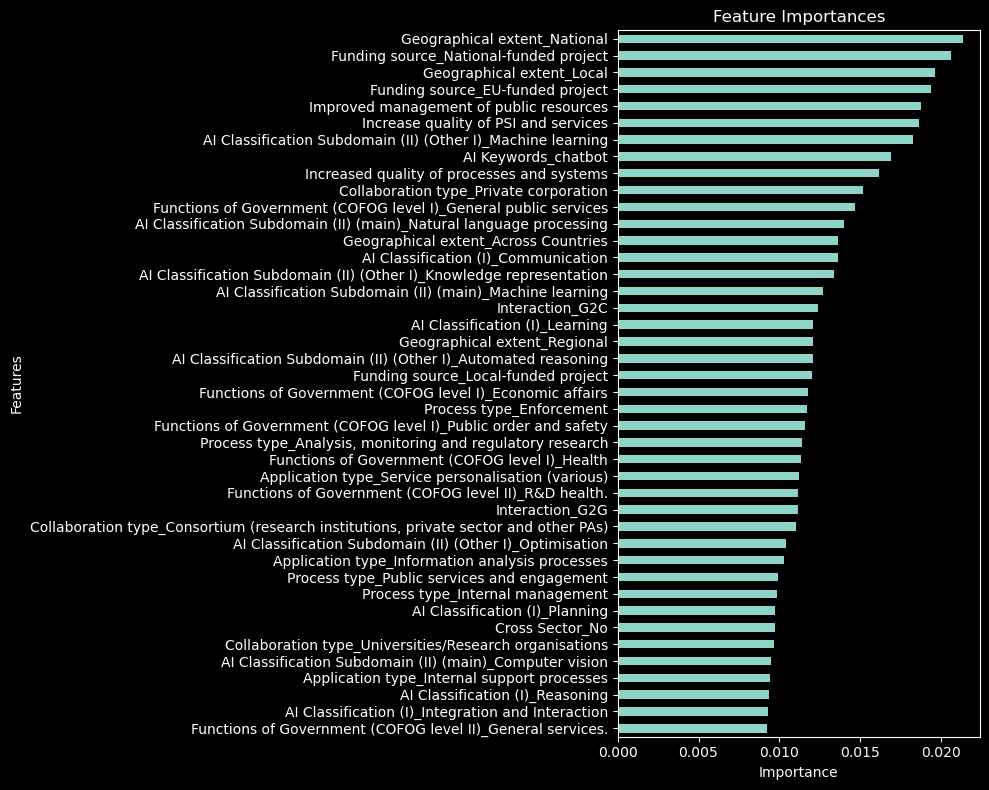

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Label encoding y-data
le = LabelEncoder()
y_encoded = le.fit_transform(df_y)

# Assigning data to variables
y_status = y_encoded
X = df_oh

# Split data
X_train_val, X_test, y_status_train_val, y_status_test, y_time_train_val, y_time_test = train_test_split(
    X, y_status, y_time, test_size=0.2, stratify=y_status, random_state=42
)

# Then split train_val into train and validation
X_train, X_val, y_status_train, y_status_val, y_time_train, y_time_val = train_test_split(
    X_train_val, y_status_train_val, y_time_train_val,
    test_size=0.25,
    stratify=y_status_train_val,
    random_state=42
)
# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train_val = scaler.transform(X_train_val)


rm_model = RandomForestClassifier()

rm_model.fit(X_train, y_status_train)

importances = rm_model.feature_importances_
feature_names = X.columns

print(feature_names)
feat_df = pd.DataFrame({
  'Feature': feature_names,
  'Importance': importances
})

filtered_df = feat_df[feat_df['Importance'] > 0.009]

filtered_df = filtered_df.sort_values(by='Importance', ascending=True)

# print(importances)

filtered_df.plot(
    kind='barh',
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(10, 8)
)

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

plt.show() 

Classes in y_val: [0 1 2 3 4]
Index(['Geographical extent', 'Functions of Government (COFOG level I)',
       'Functions of Government (COFOG level II)', 'Process type',
       'Application type', 'Cross Border', 'Cross Sector', 'Interaction',
       'Increase quality of PSI and services',
       'Improved management of public resources',
       'Increased quality of processes and systems', 'AI Classification (I)',
       'AI Classification Subdomain (II) (main)',
       'AI Classification Subdomain (II) (Other I)', 'AI Keywords',
       'Collaboration type', 'Funding source'],
      dtype='object')
[0.07812869 0.08277782 0.12637703 0.04774874 0.09452413 0.01513857
 0.01764752 0.02965327 0.02495483 0.02698661 0.02462284 0.06581103
 0.07256143 0.10095033 0.07728186 0.06592689 0.04890839]


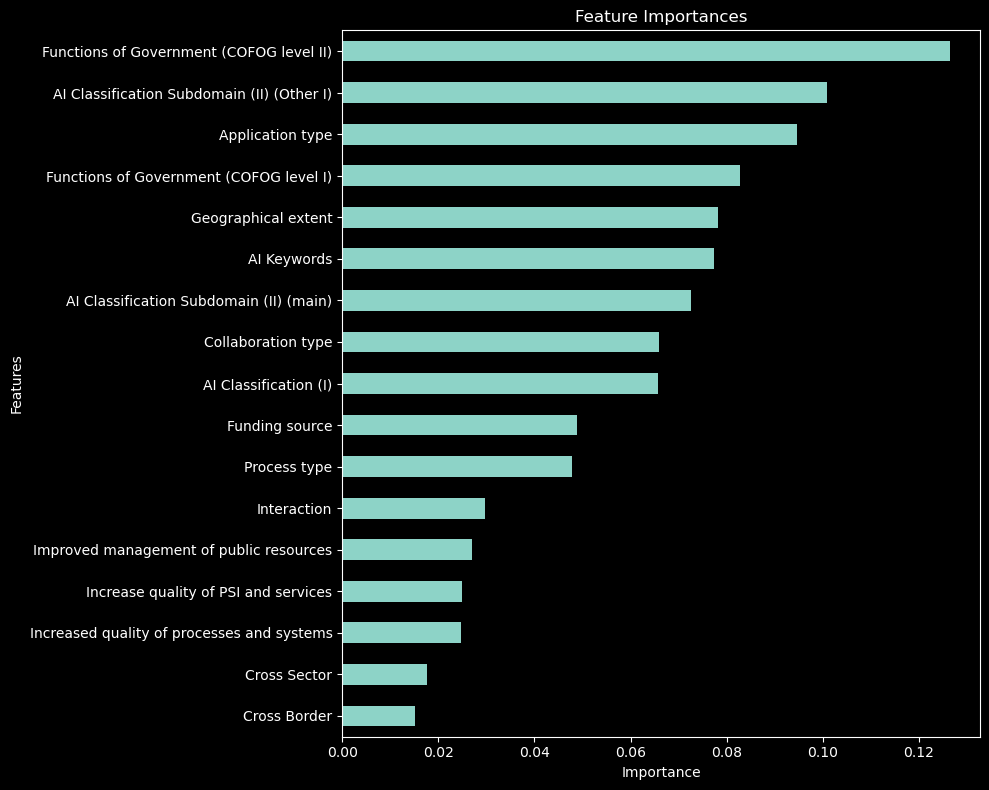

In [ ]:
y_fi = y_encoded
X_fi = df_oe

X_train_val_fi, X_test_fi, y_train_val_fi, y_test_fi = train_test_split(X_fi, y_fi, random_state=42, test_size=0.2)
X_train_fi, X_val_fi, y_train_fi, y_val_fi = train_test_split(X_train_val_fi, y_train_val_fi, random_state=42, test_size=0.2) 

print("Classes in y_val:", np.unique(y_val_fi))


X_train_fi = scaler.fit_transform(X_train_fi)
X_val_fi = scaler.fit_transform(X_val_fi) 
X_test_fi = scaler.fit_transform(X_test_fi)

rm_model.fit(X_train_fi, y_train_fi)

importances = rm_model.feature_importances_
feature_names = X_fi.columns

print(feature_names)
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    })

filtered_df = feat_df
filtered_df = filtered_df.sort_values(by='Importance', ascending=True)
print(importances)

filtered_df.plot(
    kind='barh',
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(10, 8)
)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [115]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, root_mean_squared_error, classification_report
from sklearn.linear_model import LinearRegression

svc = SVC(class_weight='balanced')
rm_cl = RandomForestClassifier(random_state=42, class_weight='balanced')
et_cl = ExtraTreesClassifier(random_state=42, class_weight='balanced')
lin_reg = LinearRegression()

hypergrid_svc = {
  'kernel': ['rbf', 'poly', 'sigmoid'],
  'C': [0.1, 1, 10],
  'gamma': [0.01, 0.1, 0.5, 1]
}

hypergrid_rm = {
  'n_estimators': [10, 50, 100, 150],
  'min_samples_split': [2, 5, 10]
}

svc_model_gs = GridSearchCV(svc, hypergrid_svc, scoring='balanced_accuracy')
rm_model_gs = GridSearchCV(rm_cl, hypergrid_rm, scoring='balanced_accuracy')
et_model_gs = GridSearchCV(et_cl, hypergrid_rm, scoring='balanced_accuracy')

models_score = []

lin_reg.fit(X_train, y_time_train)
y_pred_time = lin_reg.predict(X_val)
print("Validation MAE:", mean_absolute_error(y_time_val, y_pred_time))
print("Validation RMSE:", root_mean_squared_error(y_time_val, y_pred_time))

lin_reg.fit(X_val, y_time_val)
y_pred_time_test = lin_reg.predict(X_test)
print("Validation MAE:", mean_absolute_error(y_time_test, y_pred_time))
print("Validation RMSE:", root_mean_squared_error(y_time_test, y_pred_time))

for clf in (svc_model_gs, rm_model_gs, et_model_gs):
  # Trains on the model on training data
  clf.fit(X_train, y_status_train)
  y_pred_val = clf.predict(X_val)
  
  # Prints out scoring for accuracy, precision, recall and f1 for each model
  prec_score = precision_score(y_status_val, y_pred_val, average='macro', zero_division=0)
  print(f'\nBest Estimator:\n{clf.best_estimator_}')
  print(f'\n{classification_report(y_status_val, y_pred_val, zero_division=0)}')

  models_score.append({
        'model': clf,
        'score': prec_score
  })

# Saves the best performing model based on accuracy
best_prec_model = max(models_score, key=lambda x: x['score'])
print(f'\nBest model: {best_prec_model['model'].best_estimator_}')
best_model = best_prec_model['model'].best_estimator_

Validation MAE: 1.8736604002948016
Validation RMSE: 2.5043396122198325
Validation MAE: 2.539305694820892
Validation RMSE: 3.237742953300587

Best Estimator:
SVC(C=1, class_weight='balanced', gamma=0.01)

              precision    recall  f1-score   support

           0       0.58      0.40      0.47       127
           1       0.12      0.08      0.10        36
           2       0.21      0.30      0.25        10
           3       0.54      0.72      0.61       138
           4       0.00      0.00      0.00         4

    accuracy                           0.50       315
   macro avg       0.29      0.30      0.29       315
weighted avg       0.49      0.50      0.48       315


Best Estimator:
RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=150, random_state=42)

              precision    recall  f1-score   support

           0       0.60      0.61      0.60       127
           1       0.29      0.17      0.21        3

In [117]:
# bästa modellen tränas om på train och val
best_model = best_model.fit(X_val, y_status_val)

#modell testas på testdata
bm_test_pred = best_model.predict(X_test)

print(f'\nBest Estimator:\n{clf.best_estimator_}')
print(f'\n{classification_report(y_status_val, y_pred_val, zero_division=0)}')


Best Estimator:
ExtraTreesClassifier(class_weight='balanced', min_samples_split=10,
                     n_estimators=150, random_state=42)

              precision    recall  f1-score   support

           0       0.58      0.60      0.59       127
           1       0.26      0.17      0.20        36
           2       0.29      0.20      0.24        10
           3       0.60      0.66      0.63       138
           4       0.00      0.00      0.00         4

    accuracy                           0.56       315
   macro avg       0.35      0.32      0.33       315
weighted avg       0.54      0.56      0.55       315



In [ ]:
import joblib

#modell tränas på hela datasetet
X = df_oh
y = y_encoded
X = scaler.fit_transform(X)
best_model = best_model.fit(X, y)

joblib.dump(best_model, 'best_model.pkl')
joblib.dump(df_oh, "features.pkl")
joblib.dump(y_encoded, "targets.pkl")
joblib.dump(lin_reg, "reg_model.pkl")

/home/celvin/miniconda3/envs/python_basics_env/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


['reg_model.pkl']